# Определение легендарного покемона по его характеристикам используя решающие деревья

In [193]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

dataframe = pd.read_csv(
    "https://raw.githubusercontent.com/YBI-Foundation/Dataset/refs/heads/main/Pokemon.csv",
)

In [194]:
dataframe.head()

,SN,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [195]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SN           800 non-null    int64 
 1   Name         800 non-null    object
 2   Type 1       800 non-null    object
 3   Type 2       414 non-null    object
 4   HP           800 non-null    int64 
 5   Attack       800 non-null    int64 
 6   Defense      800 non-null    int64 
 7   Sp. Attack   800 non-null    int64 
 8   Sp. Defense  800 non-null    int64 
 9   Speed        800 non-null    int64 
 10  Generation   800 non-null    int64 
 11  Legendary    800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


### **Задача.** Выберите бинарную переменную (или сконструируйте из количественной)

Из данного списка можно назначить переменную `Legendary` - `target`

### **Задача.** Выберите несколько объясняющих переменных

Мультиколлинеарность не представляет проблемы для решающих деревьев. Можно взять все числовые переменные.

### **Задача.** Разделите датасет на обучающую и тестовую выборки

In [196]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_target, test_target = train_test_split(
    dataframe[["HP", "Attack", "Defense", "Sp. Attack", "Sp. Defense", "Speed", "Generation"]],
    dataframe["Legendary"],
    test_size=0.3,
    random_state=42,
    stratify=dataframe["Legendary"],
)

### **Задача.** Обучите модель решающего дерева на обучающей выборке

In [197]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Нормализация данных
preprocessor = ColumnTransformer(
    transformers=(
        (
            "num",
            StandardScaler(),
            make_column_selector(dtype_include=["int64"]),
        ),
    ),
)

model = Pipeline(
    [("preprocessing", preprocessor), ("classifier", DecisionTreeClassifier(class_weight="balanced", random_state=42))],
)

model.fit(train_features, train_target)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=(('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7efea5cdde10>),))),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

### **Задача** Проведите подбор гиперпараметров с помощью GridSearchCV

In [198]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__max_depth": range(2, 5),
    "classifier__min_samples_split": range(2, 15, 3),
    "classifier__min_samples_leaf": range(2, 50, 5),
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_features": ["sqrt", "log2", None],
}
grid = GridSearchCV(model, param_grid, scoring="recall_micro")
grid.fit(train_features, train_target)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=(('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7efea5cdde10>),))),
                                       ('classifier',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': range(2, 5),
                         'classifier__max_features': ['sqrt', 'log2', None],
                         'classifier__min_samples_leaf': range(2, 50, 5),
                         'classifier__min_samples_split': range(2, 15, 3)},
             scoring='recall_micro')

Наилучшими результатами обладает модель со следующими параметрами

In [199]:
grid.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 4,
 'classifier__max_features': None,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 5}

### Задача. Постройте график с разделяющей линией

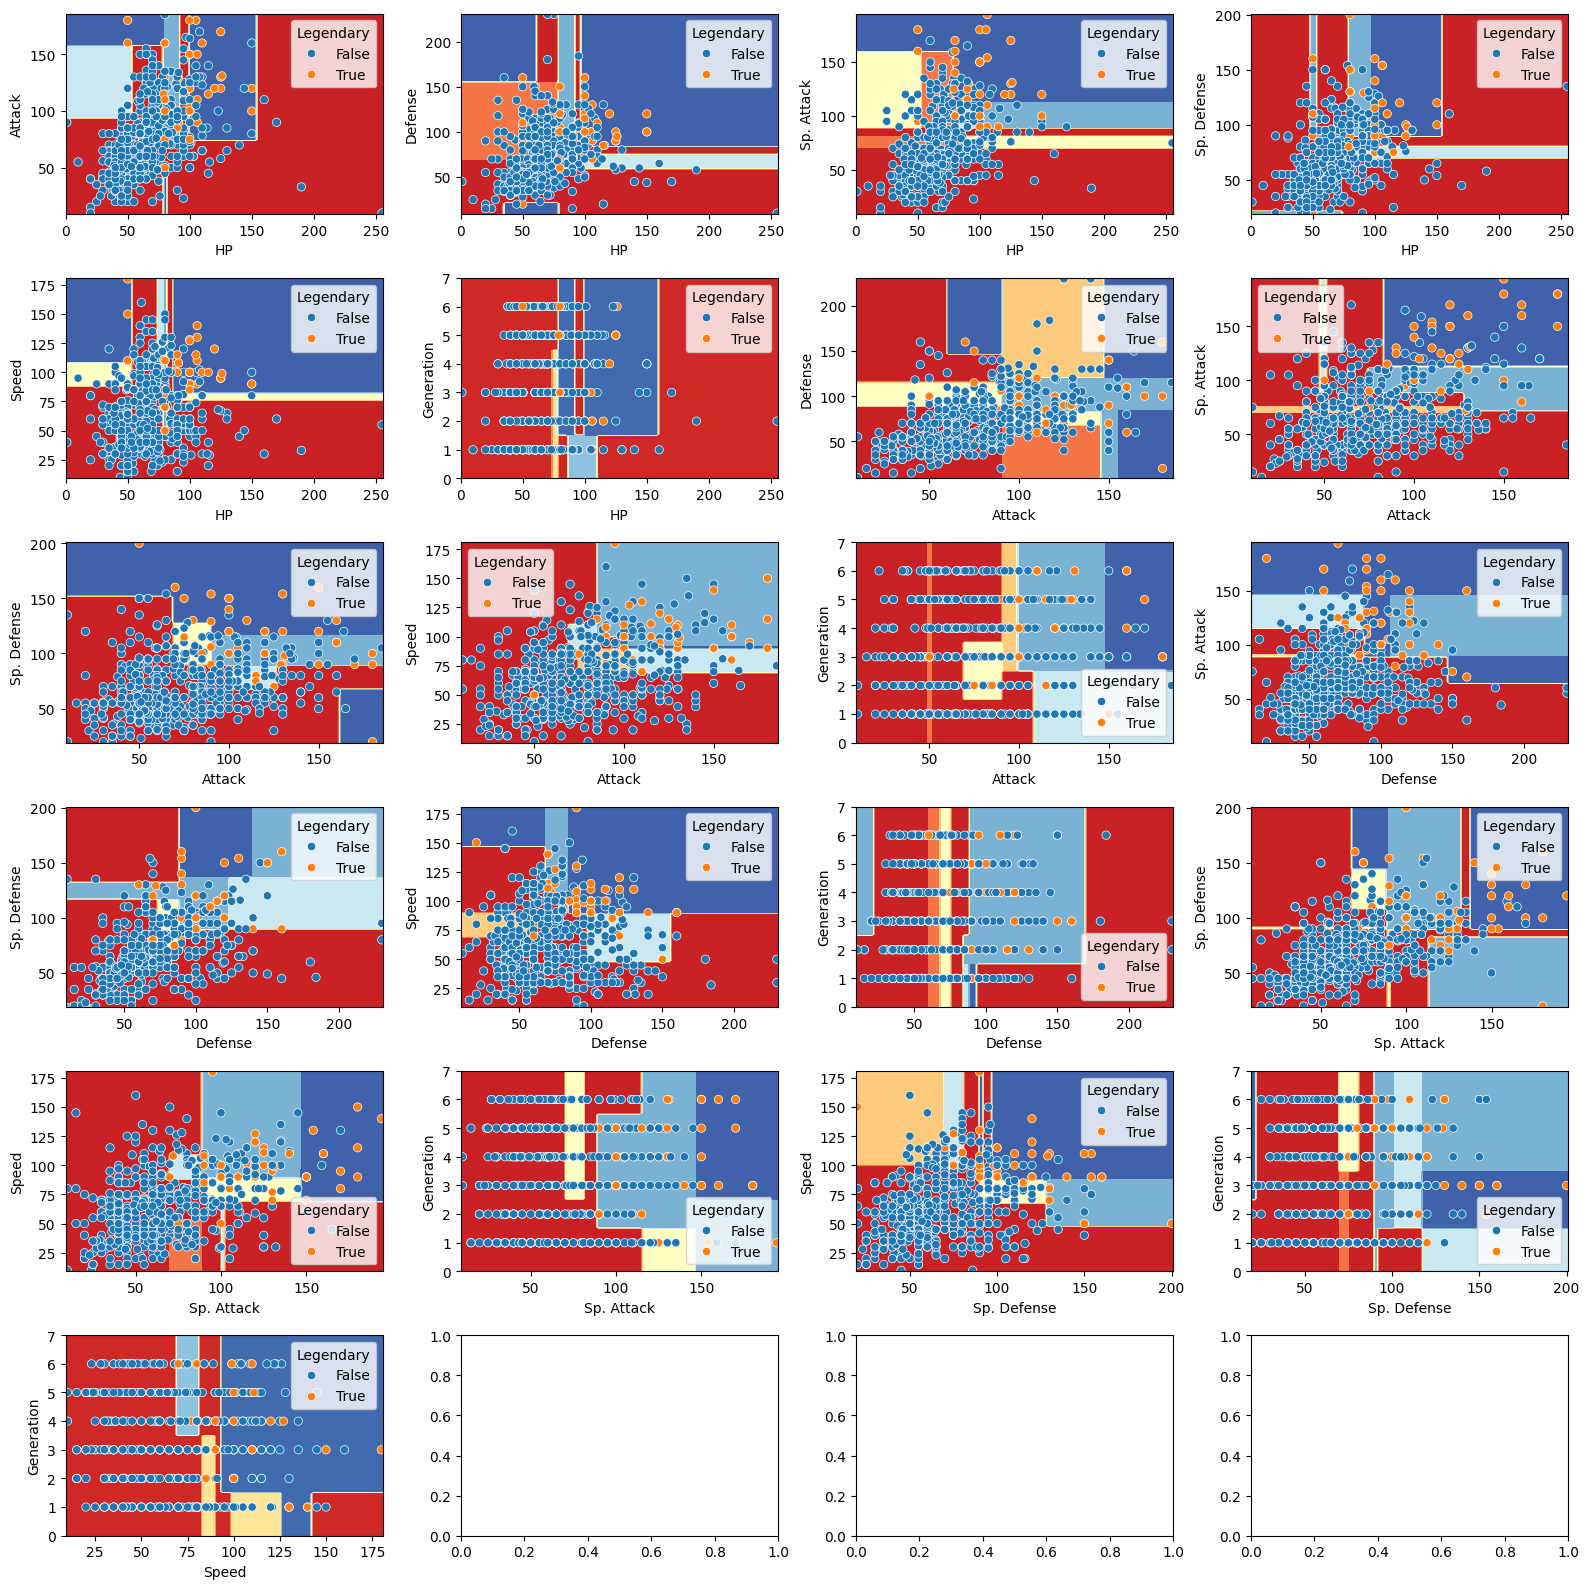

In [200]:
from itertools import combinations

from sklearn.base import clone as sklearn_clone
from sklearn.inspection import DecisionBoundaryDisplay

# Копия датафрейма с таргет переменной для первого графика с точками
train_features_with_target = train_features.copy()
train_features_with_target["Legendary"] = train_target
# Всевозможные комбинации фичей друг с другом
colpars = list(combinations(["HP", "Attack", "Defense", "Sp. Attack", "Sp. Defense", "Speed", "Generation"], 2))

# Матрица с графиками, расчет исходя из количества комбинаций
n = len(colpars) ** 0.5 + 0.5
n = int(n)
fig, axes = plt.subplots(n + 1, n - 1, figsize=(16, 16))


# Для каждой из комбинаций график с разделяющей линией
for colpar, ax in zip(colpars, axes.flat):
    colpar = list(colpar)
    model_copy = sklearn_clone(grid.best_estimator_)
    model_copy.fit(train_features[colpar], train_target)

    # разделяющая линия
    DecisionBoundaryDisplay.from_estimator(
        model_copy,
        train_features_with_target[colpar],
        ax=ax,
        cmap=plt.cm.RdYlBu,
        response_method="predict_proba",
    )

    # построение фичей
    sns.scatterplot(data=train_features_with_target, x=colpar[0], y=colpar[1], hue="Legendary", ax=ax)

plt.tight_layout()
plt.show()

### **Задача.** Сделайте предсказания целевой переменной для тестовой выборки

In [201]:
test_predict = grid.predict(test_features)

### **Задача.** Постройте матрицу ошибок

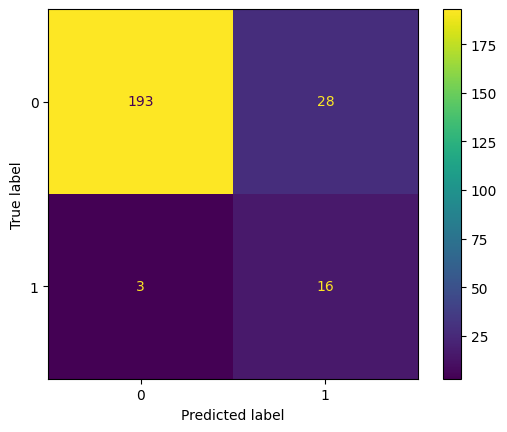

In [202]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

conf_m = confusion_matrix(y_true=test_target, y_pred=test_predict)
disp = ConfusionMatrixDisplay(conf_m)
disp.plot()
plt.show()

### **Задача.** Рассчитайте метрики качества

In [203]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_target, y_pred=test_predict))

              precision    recall  f1-score   support

       False       0.98      0.87      0.93       221
        True       0.36      0.84      0.51        19

    accuracy                           0.87       240
   macro avg       0.67      0.86      0.72       240
weighted avg       0.94      0.87      0.89       240



### **Задача.** Сделайте выводы относительно полученной модели, ее качества и полученных зависимостей

Полнота (`recall`) составляет 0.84 - это значит что всего 16% легендарных покемонов были отмечены обычными (не распознаны), что является хорошим результатом в данной задаче. В тоже время `precision` составляет 0.36 это означает что ложноположительные результаты составляют 64% (покемоны которые были классифицированы как легендарные на самом деле такими не являются). Также стоит отметить, что удается отсеять большой пласт обычных покемонов около 87% (`recall` для False). В целом учитывая дисбаланс классов средняя точность составляет 0.67 и средняя полнота 0.86. Низкая точность из-за большого количества ложноположительных срабатываний возможно является некоторым компромиссом небольшому количеству ложноотрицательных результатов.